In [44]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_left_afitted = [0] * 50
        self.recent_left_bfitted = [0] * 50
        self.recent_left_cfitted = [0] * 50
        self.recent_right_afitted = [0] * 50
        self.recent_right_bfitted = [0] * 50
        self.recent_right_cfitted = [0] * 50
        self.recent_fit_counter = 0
        #average x values of the fitted line over the last n iterations
        self.bestleftx = np.empty(3)
        self.bestrightx = np.empty(3)        

        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.currentleft_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])  
        self.currentright_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
        self.currentFitValidity = False
        #radius of curvature of the line in some units
        self.L_radius_of_curvature = [0] * 50
        self.R_radius_of_curvature = [0] * 50
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        #array of vehicle position
        self.vehicleposition = [0] * 50
        self.center = 0
        #array of lanecurve
        self.arraycurve = [0] * 50
        #array of lanecurve
        self.currentcurve = 0
#         self.R_currentcurve = 0
        self.curveCounter = 0
        self.curveValidity = False

        
    def readbestfit(self):
        return self.bestleftx[0],self.bestleftx[1],self.bestleftx[2],self.bestrightx[0],self.bestrightx[1],self.bestrightx[2]
    
    def appendValues(self,l0,l1,l2,r0,r1,r2):
    
        if self.recent_fit_counter < 50:    
             
            self.recent_left_afitted[self.recent_fit_counter] = l0
            self.recent_left_bfitted[self.recent_fit_counter] = l1
            self.recent_left_cfitted[self.recent_fit_counter] = l2
            self.recent_right_afitted[self.recent_fit_counter] = r0
            self.recent_right_bfitted[self.recent_fit_counter] = r1
            self.recent_right_cfitted[self.recent_fit_counter] = r2            
        else:
            self.recent_fit_counter = 0  
            self.currentFitValidity = True
            self.recent_left_afitted[self.recent_fit_counter] = l0
            self.recent_left_bfitted[self.recent_fit_counter] = l1
            self.recent_left_cfitted[self.recent_fit_counter] = l2
            self.recent_right_afitted[self.recent_fit_counter] = r0
            self.recent_right_bfitted[self.recent_fit_counter] = r1
            self.recent_right_cfitted[self.recent_fit_counter] = r2 
            self.detected = True
            
        self.recent_fit_counter += 1
        
        if self.currentFitValidity == True:
            #store mean for past 50 lane pixel positions from the list
            self.bestleftx[0] = np.average(self.recent_left_afitted[-50:])
            self.bestleftx[1] = np.average(self.recent_left_bfitted[-50:])
            self.bestleftx[2] = np.average(self.recent_left_cfitted[-50:])

            self.bestrightx[0] = np.average(self.recent_right_afitted[-50:])
            self.bestrightx[1] = np.average(self.recent_right_bfitted[-50:])
            self.bestrightx[2] = np.average(self.recent_right_cfitted[-50:]) 
    def curvature(self,left,right,cent):   
        #Determine road curvature and predict left or right turn
        
        if (left + 300) > right or cent < 0.15:
            #roads does not have similar cuvature
            self.detected = False #use sliding pannel
#             self.currentcurve  = left
            self.currentcurve = np.mean(self.L_radius_of_curvature[-10:])
        elif (right + 300) > left or cent > 0.30:
            self.detected = False #use sliding pannel method
#             self.currentcurve  = right
            self.currentcurve = np.mean(self.R_radius_of_curvature[-10:])
        else:
            #roads have similar cuvature
            self.detected = True #use search poly method
        self.center = np.mean(self.vehicleposition[-10:])  

        #store last 50 curvature   
        if self.curveCounter < 50:
            self.L_radius_of_curvature[self.curveCounter] = left
            self.R_radius_of_curvature[self.curveCounter] = right
            self.vehicleposition[self.curveCounter]= cent
        else:
            self.curveCounter= 0
            self.L_radius_of_curvature[self.curveCounter] = left
            self.R_radius_of_curvature[self.curveCounter] = right
            self.vehicleposition[self.curveCounter]= cent
            self.curveValidity = True
        self.curveCounter += 1

        
Lanetrack = Line()  
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def findImgpts(images):
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corner
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)


def cal_undistort(img, objpts, imgpts):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

#  pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100),binaryform=0):
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    if binaryform == 0:
        
        # Stack each channel
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
        return color_binary
    
    elif binaryform == 1:
        
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        return combined_binary
    
def get_binaryimage(image):
    offset = 100
    
    # returns undistorted image
    undistorted = cal_undistort(image, objpoints, imgpoints)
    
    #Use color transforms, gradients, etc., to create a 
    # thresholded combined binary image
    CombinedBinaryImage = pipeline(undistorted,s_thresh=(180, 255), sx_thresh=(20, 100),binaryform = 1)

    
    return CombinedBinaryImage

def get_binaryWarped(image,objpoints,imgpoints):
    offset = 100
    # returns undistorted image
    undistorted = cal_undistort(image, objpoints, imgpoints)
    #Use color transforms, gradients, etc., to create a 
    # thresholded combined binary image
    ThresholdedCombinedBinaryImage = pipeline(undistorted,s_thresh=(180, 255), sx_thresh=(20, 100),binaryform = 1)
    #thresholded combined binary image size
    img_size = (ThresholdedCombinedBinaryImage.shape[1], ThresholdedCombinedBinaryImage.shape[0])
    
    #source and destination points for generating perspecive. Prepared from a interactive tool 
    src = np.float32(
            [[707,463], #top right
             [1053,686], #bottom right
             [231,701], #bottom left
             [572,467]]) #top left


    dst = np.float32([[img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset], 
                       [offset, offset]])  

    M = cv2.getPerspectiveTransform(src, dst)

    binary_warped = cv2.warpPerspective(ThresholdedCombinedBinaryImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    return binary_warped


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit_ = np.empty(3)
    right_fit_ = np.empty(3)
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_[0], left_fit_[1], left_fit_[2],right_fit_[0],right_fit_[1],right_fit_[2] = Lanetrack.readbestfit()
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_fit_,right_fit_, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx,left_fit_,right_fit_, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return out_img, left_fitx, right_fitx, (left_fit_, right_fit_), ploty

def InversePerspective(out_image,oriimage, left_fit, right_fit):
    offset = 100
    ploty = np.linspace(0, out_image.shape[0] - 1, out_image.shape[0])
    color_img = np.zeros_like(out_image)

    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))

    cv2.fillPoly(color_img, np.int_(points), (0, 255, 0))
    
    src = np.float32(
            [[707,463], #top right
             [1053,686], #bottom right
             [231,701], #bottom left
             [572,467]]) #top left

    img_size = (oriimage.shape[1], oriimage.shape[0])
    
    dst = np.float32([[img_size[0]-offset, offset], 
                  [img_size[0]-offset, img_size[1]-offset], 
                  [offset, img_size[1]-offset], 
                   [offset, offset]])  
    # Given src and dst points, calculate the perspective transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)

    # unWarp the image using OpenCV warp inverse Perspective()    
    InversePers = cv2.warpPerspective(color_img, Minv, img_size, flags=cv2.INTER_LINEAR)
    InversePers = cv2.addWeighted(oriimage, 1, InversePers, 0.9, 0)
    return InversePers

In [27]:
import cv2
import numpy as np
import os
%matplotlib inline

newSearch = True


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
SamCalibImg = glob.glob('../camera_cal/calibration*.jpg')

# Find object and image points
findImgpts(SamCalibImg)

def process_image(image):
    binary_warped = get_binaryWarped(image,objpoints,imgpoints)
    
    out_img, left_curve,right_curve,lanes, ploty= search_around_poly(binary_warped) # use search poly

    imgFinal = InversePerspective(out_img,image, left_curve, right_curve)
    
    return imgFinal

## Video output

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
white_output = 'example_searchpoly_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("../project_video.mp4").subclip(0,5)
# clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                     | 0/125 [00:00<?, ?it/s, now=None]

Moviepy - Building video example_searchpoly_project_video.mp4.
Moviepy - Writing video example_searchpoly_project_video.mp4



Moviepy - Done !
Moviepy - video ready example_searchpoly_project_video.mp4
Wall time: 2min 44s


##### play video inline

In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## search poly method

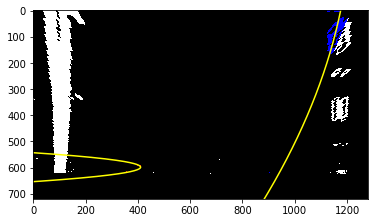

In [45]:
import cv2
import numpy as np
import os
%matplotlib inline




# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
SamCalibImg = glob.glob('../camera_cal/calibration*.jpg')

# Find object and image points
findImgpts(SamCalibImg)

image = mpimg.imread('../test_images/straight_lines1.jpg')

binary_warped = get_binaryWarped(image,objpoints,imgpoints)
    
out_img, left_curve,right_curve,lanes, ploty= search_around_poly(binary_warped) # use search poly

plt.imshow(out_img)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()
# ax1.set_axis_off()
# ax1.imshow(image)
# ax1.set_title('Original Image', fontsize=50)
# ax2.set_axis_off()
# ax2.imshow(out_img)
# ax2.set_title('search polynomials', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)